# Predictions

In this notebook you will learn how to build a link prediction classifier using Neo4j and scikit-learn.   
在本笔记本中，您将学习如何使用Neo4j和scikit-learn构建链接预测分类器。

Import the libraries that you will need (remember to unset Reset all runtimes before running):  
导入你需要的库(记得在运行前重置所有运行时):

In [35]:
from py2neo import Graph
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import pandas as pd
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

Next, create a connection to your Neo4j Sandbox, just as you did previously when you set up your environment.   
接下来，创建到Neo4j沙箱的连接，就像之前设置环境时所做的一样。

<div align="left">
    <img src="images/sandbox-citations.png" alt="Citation Sandbox"/>
</div>

Update the cell below to use the IP Address, Bolt Port, and Password, as you did previously.  
像前面一样，更新下面的单元格，使用IP地址、Bolt端口和密码。

In [2]:
# Change the line of code below to use the IP Address, Bolt Port,  and Password of your Sandbox.
# graph = Graph("<Bolt URL>", auth=("neo4j", "<Password>")) 
 
graph = Graph("bolt://100.25.48.12:37028", auth=("neo4j", "auto-development-gunnery"))

# Building a co-author graph

You will build an inferred graph of co-authors based on people collaborating on the same papers. You will store a property on the relationship indicating the year of their first collaboration.  
您将基于在同一篇论文上进行协作的人员构建一个推断的合著者图表。您将在关系上存储一个属性，该属性指示它们第一次协作的年份。

Run this code to do this:  
运行这段代码来做这件事:

In [3]:
query = """
CALL apoc.periodic.iterate(
    "MATCH (a1)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author)
    WITH a1, a2, paper
    ORDER BY a1, paper.year
    RETURN a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations",
    "MERGE (a1)-[coauthor:CO_AUTHOR{year:year}]-(a2)
    SET coauthor.collaborations = collaborations",
    {batchSize: 100}
)
"""

graph.run(query).stats()

constraints_added: 0
constraints_removed: 0
contains_updates: False
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 0
relationships_created: 0
relationships_deleted: 0

Now that you have created a co-author graph, you need an approach that will allow you to predict future links (relationships) that will be created between people.   
现在您已经创建了一个合著者图表，您需要一种方法来预测将来人与人之间将创建的链接(关系)。

You will use the [link prediction algorithms](https://neo4j.com/docs/graph-algorithms/current/algorithms/linkprediction/) that you learned about in the previous section. Once you have computed scores with this algorithms what should you do?  
您将使用您在上一节中了解到的[link prediction algorithms](https://neo4j.com/docs/graph-algorithms/current/algorithms/linkprediction/)。一旦你用这个算法计算了分数，你应该怎么做?

There are two main approaches that one can take:  
我们可以采取两种主要方法:

## Using the measures directly

You can use the scores from the link predictions directly, specifying a __threshold value__ above which we predict that a link will be created between two nodes.  
您可以直接使用来自链接预测的分数，指定一个值为__threshold的值__，在该值之上，我们预测将在两个节点之间创建一个链接。

## Supervised learning

You can take a supervised learning approach where you use the scores as features to train a binary classifier. The binary classifier then predicts whether a pair of nodes will have a link.  
您可以采用监督学习方法，使用分数作为特征来训练二进制分类器。然后，二进制分类器预测一对节点是否具有链接。

In this notebook you will apply the supervised learning approach.  
在这本笔记本里，你将运用监督学习的方法。

## Train and test datasets 

Next, you must create the train and test datasets on which you can build, and then evaluate a model.  
接下来，您必须创建可以在其上构建的培训和测试数据集，然后评估模型。

## Positive examples

The tricky thing when working with graph data is that you cannot just randomly split the data, as this could lead to data leakage.  
处理图形数据时需要注意的一点是，不能随意分割数据，因为这会导致数据泄漏。

Data leakage can occur when data outside of your training data is inadvertently used to create your model. This can easily happen when working with graphs because pairs of nodes in the training set may be connected to those in the test set.  
当您的培训数据之外的数据无意中用于创建模型时，可能会发生数据泄漏。这在处理图时很容易发生，因为训练集中的节点对可能连接到测试集中的节点对。

When you compute link prediction measures over that training set the __measures computed contain information from the test set__ that you will later evaluate the model against.  
当您在训练集上计算链接预测度量时，所计算的度量包含来自测试集__的信息，稍后您将根据这些信息对模型进行评估。

Instead, you need to split the graph into training and test sub graphs. If the graph has a concept of time, things are easier as you can split the graph at a point in time. The training set will be from before the time, the test set after.  
相反，您需要将图形分割为训练和测试子图。如果图中有时间的概念，事情就容易多了，因为您可以在某个时间点上分割图。训练集将从时间之前开始，测试集从时间之后开始。

This is still not a perfect solution and you must ensure that the general network structure in the training and test sub graphs is similar.  
这仍然不是一个完美的解决方案，您必须确保训练和测试子图中的一般网络结构是相似的。

Subsequently, pairs of nodes in our train and test datasets will have relationships between them. They will be the __positive examples__ in your machine learning model.  
随后，我们的培训和测试数据集中的节点对之间将有关系。它们将是你的机器学习模型中最典型的正面例子。

Because the citation graph contains times, you can create train and test graphs by splitting the data on a particular year. Next, you must determine what year that should be. Determine the distribution of the first year that co-authors collaborated:  
由于引文图包含时间，您可以通过分割特定年份的数据来创建培训和测试图。接下来，您必须确定应该是哪一年。确定合作作者第一年的分布情况:

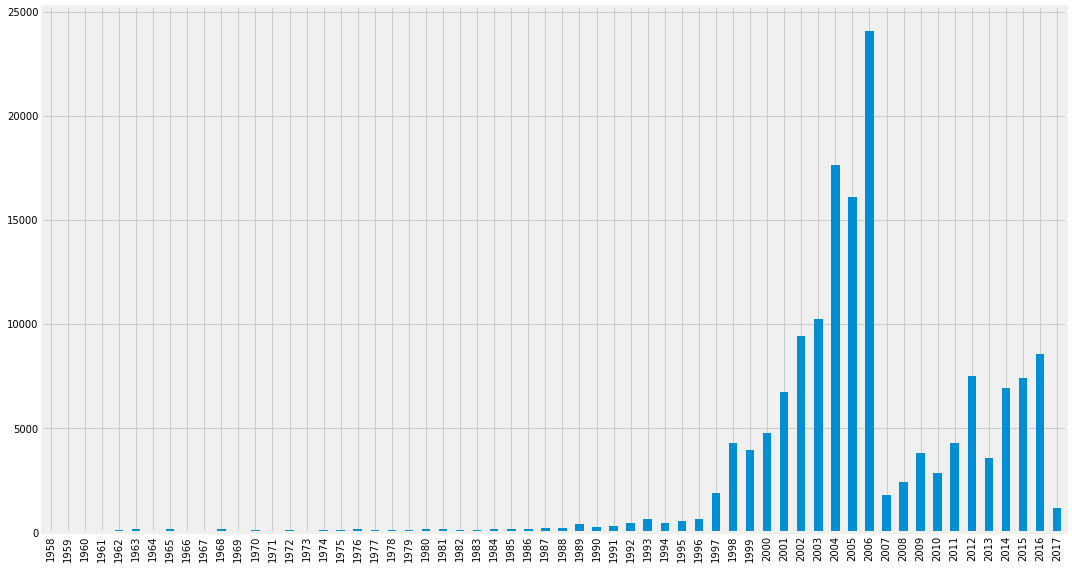

In [5]:
query = """
MATCH p = ()-[r:CO_AUTHOR]->()
WITH r.year AS year, count(*) AS count
ORDER BY year
RETURN toString(year) AS year, count
"""

by_year = graph.run(query).to_data_frame()

ax = by_year.plot(kind = 'bar', x = "year", y="count", legend=None, figsize=(15,8))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

It looks like 2006 would act as a good year for splitting the data. All co-authorships from 2005 and earlier as our train graph, and everything from 2006 onwards as the test graph.  
看起来，2006年将是数据拆分的好年份。所有的合作作者从2005年开始作为我们的火车图，从2006年开始作为测试图。

Create explicit `CO_AUTHOR_EARLY` and `CO_AUTHOR_LATE` relationships in the graph based on that year. The following code will create these relationships:  
根据那年在图中创建显式的`CO_AUTHOR_EARLY`和`CO_AUTHOR_LATE`关系。下面的代码将创建这些关系:


In [6]:
query = """
MATCH (a)-[r:CO_AUTHOR]->(b)
where r.year < 2006
MERGE (a)-[:CO_AUTHOR_EARLY{year: r.year}]-(b)
"""
graph.run(query).stats()

constraints_added: 0
constraints_removed: 0
contains_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 81096
relationships_created: 81096
relationships_deleted: 0

In [7]:
query = """
MATCH (a)-[r:CO_AUTHOR]->(b)
where r.year  >= 2006
MERGE (a)-[:CO_AUTHOR_LATE{ year:r.year}]-(b)
"""

graph.run(query).stats()

constraints_added: 0
constraints_removed: 0
contains_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 74128
relationships_created: 74128
relationships_deleted: 0

Determine how many co-author relationship you have in each of these sub graphs:  
确定每个子图中有多少个合作者关系:

In [10]:
query = """
MATCH ()-[:CO_AUTHOR_EARLY]->() 
RETURN count(*) AS count
"""

graph.run(query).to_data_frame()

,count
0,81096


In [11]:
query = """
MATCH ()-[:CO_AUTHOR_LATE]->() 
RETURN count(*) AS count
"""

graph.run(query).to_data_frame()

,count
0,74128


This graph has a split of 52-48, which is a bit on the high side, but should be ok. Next, we create our __negative examples__.  
这张图有52-48的分割，这有点高，但应该没问题。接下来，我们创建我们的……negative examples__。


## Negative examples

The simplest approach is to use all pair of nodes that don’t have a relationship. __The problem with this approach is that there are significantly more examples of pairs of nodes that don’t have a relationship than there are pairs of nodes that do__.  
最简单的方法是使用所有没有关系的节点对。这种方法的问题是，没有关系的节点对比有do__关系的节点对要多得多。

The maximum number of negative examples is equal to:  
负例的最大个数为:

```
# negative examples = (# nodes)² - (# relationships) - (# nodes)
```

i.e. the number of nodes squared, minus the relationships that the graph has, minus self relationships.
节点数的平方，减去图中的关系，减去自关系。

If you were to use all of these negative examples in your training set, you would have a massive class imbalance — there are many negative examples and relatively few positive ones.  
如果你在你的训练集中使用所有这些负面的例子，你会有一个巨大的阶级不平衡-有很多负面的例子和相对较少的积极的例子。

A model trained using data that is this imbalanced will achieve very high accuracy by __predicting that any pair of nodes don’t have a relationship__ between them, which is not quite what we want!  
使用这种不平衡的数据训练的模型将通过预测任意一对节点之间没有关系来达到非常高的精度，这不是我们想要的!

You need to reduce the number of negative examples. An approach described in several link prediction papers is to use pairs of nodes that are a __specific number of hops away from each other__.  
你需要减少负面例子的数量。在几篇链接预测论文中描述的一种方法是使用一对节点，它们之间的跳数是特定的。

This will significantly reduce the number of negative examples, although there will still be a lot more negative examples than positive.  
这将大大减少负面例子的数量，尽管负面例子仍将远远多于正面例子。

To solve this problem, you either need to down sample the negative examples or up sample the positive examples.  
要解决这个问题，你要么向下采样负面的例子，要么向上采样正面的例子。

You will take the down sampling approach. The following function will do this:  
你将采取向下抽样的方法。下面的函数将这样做:

In [17]:
def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0]
    un = Counter(copy.label.values)[1]
    n = zero - un
    copy = copy.drop(copy[copy.label == 0].sample(n=n, random_state=1).index)
    return copy.sample(frac=1)

Now you are ready to build the train and test datasets based on the train and test sub graphs that you created.   
现在，您已经准备好基于所创建的火车和测试子图构建火车和测试数据集。

* The positive examples will be taken directly from the graph. 
* The negative examples will be found by looking for people who are 2 or 3 hops away from each other, excluding those that have already collaborated. You will then down sample those examples to equal the size of the positive examples. 


* 正面的例子将直接取自图表。
* 负面的例子可以通过寻找相距2到3跳的人来找到，不包括那些已经合作过的人。然后，您将对这些示例进行采样，使其与正示例的大小相等。

In [14]:
train_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_EARLY]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

train_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_EARLY]-()
MATCH (author)-[:CO_AUTHOR_EARLY*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR_EARLY]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
train_missing_links = train_missing_links.drop_duplicates()

In [18]:
training_df = train_missing_links.append(train_existing_links, ignore_index=True)
training_df['label'] = training_df['label'].astype('category')
training_df = down_sample(training_df)

Now let's have a look what our train DataFrame contains:  
现在让我们看看我们的火车数据包含什么:

In [19]:
training_df.head()

,label,node1,node2
1049590,1,170799,255579
94978,0,11598,151245
634319,0,130427,36304
1027967,1,35701,166438
1033408,1,161386,192299


Let's repeat the process for the test set:  
让我们对测试集重复这个过程:

In [21]:
test_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_LATE]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

test_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_EARLY]-()
MATCH (author)-[:CO_AUTHOR_EARLY*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR_LATE]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()

test_missing_links = test_missing_links.drop_duplicates()

In [22]:
test_df = test_missing_links.append(test_existing_links, ignore_index= True)
test_df['label'] = test_df['label'].astype('category')
test_df = down_sample(test_df)

And it's time to sample our test DataFrame:  
是时候对我们的测试数据进行采样了:

In [23]:
test_df.head()

,label,node1,node2
632407,0,107164,129119
287230,0,37130,2005
1183918,1,248568,248570
1182185,1,245831,245833
1071935,0,248715,248718


# Choosing a machine learning algorithm

Next, you will create a machine learning pipeline based on a random forest classifier. This method is well suited as this data set will be comprised of a mix of strong and weak features. While the weak features will sometimes be helpful, the random forest method will ensure that you don’t create a model that only fits the training data.  
接下来，您将创建一个基于随机森林分类器的机器学习管道。这个方法非常适合，因为这个数据集将由强特性和弱特性混合组成。虽然弱特性有时会有帮助，但是random forest方法将确保您不会创建只适合训练数据的模型。

In [38]:
classifier = RandomForestClassifier(n_estimators=30,  max_depth=10, random_state=0)

# Generating graphy features

Start by creating a simple model that tries to predict whether two authors will have a future collaboration based on features extracted from common authors, preferential attachment, and the total union of neighbors.  首先创建一个简单的模型，该模型试图根据从共同作者中提取的特征、优先附件和邻居的总联合来预测两个作者是否会有未来的合作。

The following function computes each of these measures for pairs of nodes:  
下面的函数计算每一对节点的这些度量:

In [27]:
def apply_graphy_features(data, rel_type):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           algo.linkprediction.commonNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS cn,
           algo.linkprediction.preferentialAttachment(
               p1, p2, {relationshipQuery: $relType}) AS pa,
           algo.linkprediction.totalNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS tn
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    features = graph.run(query, {"pairs": pairs, "relType": rel_type}).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

Now apply the function to the training DataFrame:  
现在将该函数应用到训练数据aframe中:

In [28]:
training_df = apply_graphy_features(training_df, "CO_AUTHOR_EARLY")

This is what the DataFrame looks like now:  
这就是DataFrame现在的样子:

In [30]:
training_df.head()

,label,node1,node2,cn,pa,tn
0,1,170799,255579,2.000000,18.000000,7.000000
1,0,11598,151245,0.000000,44.000000,15.000000
2,0,130427,36304,0.000000,72.000000,17.000000
3,1,35701,166438,2.000000,27.000000,10.000000
4,1,161386,192299,3.000000,16.000000,5.000000


Do the same to the test DataFrame:  
对测试数据aframe执行相同的操作:

In [31]:
test_df = apply_graphy_features(test_df, "CO_AUTHOR")

In [32]:
test_df.head()

,label,node1,node2,cn,pa,tn
0,0,107164,129119,0.000000,144.000000,26.000000
1,0,37130,2005,0.000000,84.000000,20.000000
2,1,248568,248570,3.000000,16.000000,5.000000
3,1,245831,245833,2.000000,9.000000,4.000000
4,0,248715,248718,7.000000,88.000000,12.000000


Next, you will build a model based on these graphy features. You will start by just using one of the features - common neighbors.   
接下来，您将基于这些图形特性构建一个模型。您将首先使用其中一个特性—公共邻居。

The following code builds a random forest model, evaluates it against the test dataset, and then indicates which of the features had the most importance in the model.  
下面的代码构建一个随机森林模型，根据测试数据集对其进行评估，然后指出模型中哪些特性最重要。

In [39]:
columns = ["cn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Next, you need to evaluate the model. You will compute its accuracy, precision, and recall. Then, you will return the importance of each feature used in the model. The following functions will help with this:  
接下来，您需要评估模型。您将计算它的精确度、精确度和召回率。然后，您将返回模型中使用的每个特性的重要性。以下功能将有助于实现这一点:

In [44]:
def evaluate_model(predictions, actual):
    return pd.DataFrame({
        "Measure": ["Accuracy", "Precision", "Recall"],
        "Score": [accuracy_score(actual, predictions), 
                  precision_score(actual, predictions), 
                  recall_score(actual, predictions)]
    })

def feature_importance(columns, classifier):        
    display("Feature Importance")
    df = pd.DataFrame({
        "Feature": columns,
        "Importance": classifier.feature_importances_
    })
    df = df.sort_values("Importance", ascending=False)    
    ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
    ax.xaxis.set_label_text("")
    plt.tight_layout()
    plt.show()

,Measure,Score
0,Accuracy,0.807
1,Precision,0.844
2,Recall,0.753


'Feature Importance'

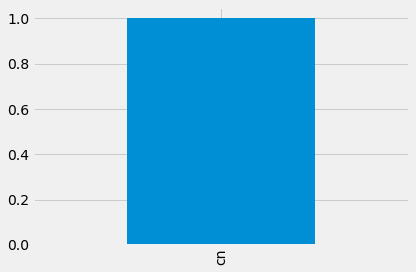

In [45]:
predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)

The scores for accuracy and precision are adequate, but the recall is not very good. What happens if you include preferential attachment and total neighbors as well?  
准确度和精密度的分数是足够的，但是召回率不是很好。如果你包括优先附件和总邻居会发生什么?

,Measure,Score
0,Accuracy,0.851
1,Precision,0.810
2,Recall,0.918


'Feature Importance'

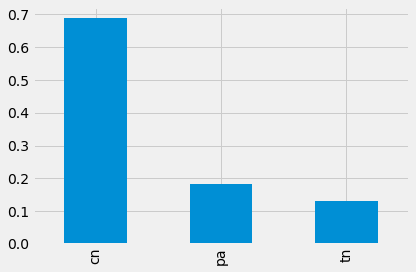

In [46]:
columns = ["cn", "pa", "tn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X,y)

predictions = classifier.predict((test_df[columns]))
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)

Common Neighbors is the dominant feature, but including the two other features has improved the accuracy and recall of the model.  
共有邻域是主要特征，但包含了其他两个特征提高了模型的准确性和召回率。

Next, you will add some new features that are generated from graph algorithms.  
接下来，您将添加一些由图算法生成的新特性。

# Triangles and The Clustering Coefficient

Start by running the [triangle count](https://neo4j.com/docs/graph-algorithms/current/algorithms/triangle-counting-clustering-coefficient/) algorithm over the test and train sub-graphs. This algorithm will return the number of triangles that each node forms, as well as each node's clustering coefficient. The clustering coefficient of a node indicates the likelihood that its neighbors are also connected.  
首先在测试和训练子图上运行[triangle count](https://neo4j.com/docs/graph-algorithms/current/algorithms/triangle-counting-clustering-coefficient/)算法。该算法将返回每个节点形成的三角形数，以及每个节点的聚类系数。节点的聚类系数表示其相邻节点也连接的可能性。

In [48]:
query = """
CALL algo.triangleCount("Author", "CO_AUTHOR_EARLY", {write:true,
writerProperty:'trianglesTrain', clusteringCoefficientProperty:'coefficientTrain'})
"""

graph.run(query).to_data_frame()

,averageClusteringCoefficient,clusteringCoefficientProperty,computeMillis,loadMillis,nodeCount,p1,p10,p100,p25,p5,p50,p75,p90,p95,p99,postProcessingMillis,triangleCount,write,writeMillis,writeProperty
0,0.375,coefficientTrain,128,276,80299,0,0,787,0,0,0,3,7,15,45,405,97205,True,7,triangles


In [49]:
query = """
CALL algo.triangleCount("Author", "CO_AUTHOR",{ write:true,
writeProperty:'trianglesTest', clusteringCoefficientProperty:'coefficientTest'
})
"""

graph.run(query).to_data_frame()

,averageClusteringCoefficient,clusteringCoefficientProperty,computeMillis,loadMillis,nodeCount,p1,p10,p100,p25,p5,p50,p75,p90,p95,p99,postProcessingMillis,triangleCount,write,writeMillis,writeProperty
0,0.657,coefficientTest,178,313,80299,0,0,787,1,0,3,6,15,26,91,288,199813,True,4,trianglesTest


The following function will add these features to the train and test DataFrames:  
下面的函数将把这些特性添加到火车和测试数据流中:

In [52]:
def apply_triangles_features(data, triangles_prop, coefficient_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    apoc.coll.min([p1[$trianglesProp], p2[$trianglesProp]]) AS minTriangles,
    apoc.coll.max([p1[$trianglesProp], p2[$trianglesProp]]) AS maxTriangles,
    apoc.coll.min([p1[$coefficientProp], p2[$coefficientProp]]) AS minCoefficient,
    apoc.coll.max([p1[$coefficientProp], p2[$coefficientProp]]) AS maxCoefficient
    """    
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]    
    params = {
    "pairs": pairs,
    "trianglesProp": triangles_prop,
    "coefficientProp": coefficient_prop
    }
    features = graph.run(query, params).to_data_frame()    
    return pd.merge(data, features, on = ["node1", "node2"])

Add the new features:  
添加新功能:

In [53]:
training_df = apply_triangles_features(training_df, "z", "coefficientTrain")
test_df = apply_triangles_features(test_df, "trianglesTest", "coefficientTest")

ClientError: ProcedureCallFailed: Failed to invoke function `apoc.coll.max`: Caused by: java.lang.NullPointerException

In [ ]:
training_df.head()

In [ ]:
test_df.head()

And now let's train and evaluate a model with these features:  
现在让我们用这些特性来训练和评估一个模型:

In [ ]:
columns = [
    "cn", "pa", "tn", # graph features
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient" # triangle features  
]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)

The coefficient features have not added much to our model, but the triangles are useful. Next you will see if Community Detection algorithms can help improve the model.  
系数特征并没有给我们的模型增加多少，但是三角形是有用的。接下来，您将看到社区检测算法是否有助于改进模型。

# Community Detection

Community Detection algorithms evaluate how a group is clustered or partitioned. Nodes are considered more similar to nodes that fall in their community than to nodes in other communities.  
社区检测算法评估一个群体是如何聚集或划分的。与其他社区中的节点相比，节点被认为更类似于其所属社区中的节点。

You will run two Community Detection algorithms over the train and test sub-graphs - Label Propagation and Louvain. First, Label Propagation:   
您将在火车上运行两个社区检测算法，并测试子图—标签传播和Louvain。首先,品牌传播:

In [ ]:
graph.run("""
CALL algo.labelPropagation("Author", "CO_AUTHOR_EARLY", "BOTH",
{partitionProperty: "partitionTrain"});
""").to_data_frame()

In [ ]:
graph.run("""
CALL algo.labelPropagation("Author", "CO_AUTHOR", "BOTH",
{partitionProperty: "partitionTest"});
""").to_data_frame()

And now Louvain. The Louvain algorithm returns intermediate communities, which are useful for finding fine grained communities that exist in a graph. You will add a property to each node containing the community revealed on the first iteration of the algorithm:  
现在鲁汶。Louvain算法返回中间社区，这对于查找图中存在的细粒度社区非常有用。您将向每个节点添加一个属性，其中包含算法第一次迭代时显示的社区:

In [ ]:
graph.run("""
CALL algo.louvain.stream("Author", "CO_AUTHOR_EARLY", {includeIntermediateCommunities:true})
YIELD nodeId, community, communities
WITH algo.getNodeById(nodeId) AS node, communities[0] AS smallestCommunity
SET node.louvainTrain = smallestCommunity;
""").stats()

In [55]:
graph.run("""
CALL algo.louvain.stream("Author", "CO_AUTHOR", {includeIntermediateCommunities:true})
YIELD nodeId, community, communities
WITH algo.getNodeById(nodeId) AS node, communities[0] AS smallestCommunity
SET node.louvainTest = smallestCommunity;
""").stats()

constraints_added: 0
constraints_removed: 0
contains_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 80299
relationships_created: 0
relationships_deleted: 0

The following function will add these features to the train and test DataFrames:  
下面的函数将把这些特性添加到火车和测试数据流中:

In [56]:
def apply_community_features(data, partition_prop, louvain_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    algo.linkprediction.sameCommunity(p1, p2, $partitionProp) AS sp,    
    algo.linkprediction.sameCommunity(p1, p2, $louvainProp) AS sl
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    params = {
    "pairs": pairs,
    "partitionProp": partition_prop,
    "louvainProp": louvain_prop
    }
    features = graph.run(query, params).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [ ]:
training_df = apply_community_features(training_df, "partitionTrain", "louvainTrain")
test_df = apply_community_features(test_df, "partitionTest", "louvainTest")

In [ ]:
training_df.head()

In [ ]:
test_df.head()

In [ ]:
columns = [
    "cn", "pa", "tn", # graph features
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient", # triangle features  
    "sp", "sl" # community features
]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)